In [1]:
%matplotlib inline

import torch

import triton
import triton.language as tl

torch.cuda.set_device(3)

# Autotune

之前我们简单验证了我们自定义 GEMM kernel 的正确性，还剩下一个工作没做，也就是超参数的确定，即 `BLOCK_SIZE_M` 等值应该怎么取

这里只需要使用 `@triton.autotune` 即可，Triton 的编译器会在我们的 config 列表中找到最佳的配置，这里需要说明两个参数：

- `num_stages`：官方文档中说这个参数表示 "the number of stages that the compiler should use when software-pipelining loops"，我尝试查过相关内容，不过解释地不算很清楚，大致可以认为是 kernel 中循环结构的并行度，这是通过 Triton 编译器调整循环的实际结构实现的
- `num_warps`：当前 block 希望使用的 warp 的数量，一个 warp 对应 32 个线程

In [2]:
@triton.autotune(
    configs=[
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 64}, num_stages=3,
                      num_warps=8),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32}, num_stages=5,
                      num_warps=2),
        triton.Config({'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32}, num_stages=5,
                      num_warps=2),
    ],
    key=['M', 'N', 'K'],
)
@triton.jit
def matmul_kernel(
    A_ptr, B_ptr, C_ptr, 
    M, N, K, 
    stride_am, stride_ak, stride_bk, stride_bn, stride_cm, stride_cn,
    BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr):

    pid_m = tl.program_id(0)
    pid_n = tl.program_id(1)
    offs_am = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_bn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = A_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    b_ptrs = B_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)

    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)
        b = tl.load(b_ptrs, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K, other=0.0)
        accumulator += tl.dot(a, b)
        a_ptrs += BLOCK_SIZE_K * stride_ak
        b_ptrs += BLOCK_SIZE_K * stride_bk

    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = C_ptr + (offs_cm[:, None] * stride_cm + offs_cn[None, :] * stride_cn)
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    c = accumulator.to(tl.float16)
    tl.store(c_ptrs, c, mask=c_mask)


def grid(META):
    return (triton.cdiv(META['M'], META['BLOCK_SIZE_M']), triton.cdiv(META['N'], META['BLOCK_SIZE_N']))

def matmul(A, B):
    assert A.shape[1] == B.shape[0]
    M, K = A.shape
    K, N = B.shape
    C = torch.empty((M, N), device='cuda', dtype=torch.float16)
    matmul_kernel[grid](
        A, B, C, 
        M, N, K, 
        A.stride(0), A.stride(1), B.stride(0), B.stride(1), C.stride(0), C.stride(1),)

    return C

# Benchmark

让我们来测试一下我们的 kernel 的效率怎么样 👀

如果尝试用不同的显卡，会发现在 TITAN 上 Triton 的效率远低于 cuBLAS，但是在 A6000 上两者几乎差不多，我们可以推断是 Triton 编译器对于旧的架构优化有限导致的

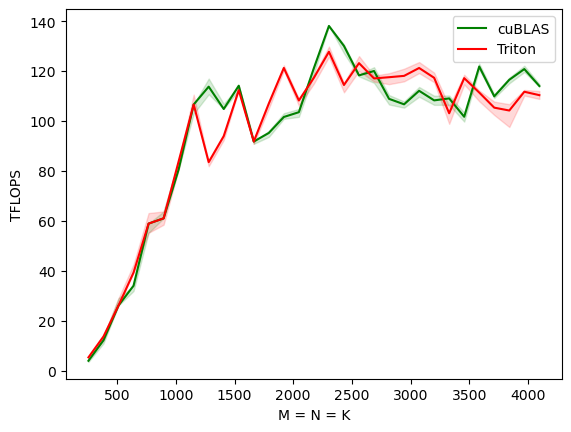

matmul-performance:
         M      cuBLAS      Triton
0    256.0    4.096000    5.461333
1    384.0   12.288000   13.824000
2    512.0   26.214401   26.214401
3    640.0   34.133334   39.384616
4    768.0   58.982401   58.982401
5    896.0   61.083825   61.083825
6   1024.0   80.659693   83.886082
7   1152.0  106.642284  106.642284
8   1280.0  113.777774   83.591839
9   1408.0  104.841847   93.996136
10  1536.0  114.159485  112.347429
11  1664.0   91.825636   91.825636
12  1792.0   95.249353  107.042134
13  1920.0  101.647057  121.263156
14  2048.0  103.563064  108.240102
15  2176.0  121.226797  117.339058
16  2304.0  138.080190  127.742633
17  2432.0  130.066963  114.437732
18  2560.0  118.296023  123.187975
19  2688.0  120.041320  117.077336
20  2816.0  108.899397  117.558512
21  2944.0  106.715271  118.094859
22  3072.0  112.124958  121.248615
23  3200.0  108.291029  117.323552
24  3328.0  109.077718  103.139390
25  3456.0  101.730688  117.182512
26  3584.0  121.836579  111.419324


In [3]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['M', 'N', 'K'],  # Argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(2, 33)],  # Different possible values for `x_name`
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=['cublas', 'triton'],
        # Label name for the lines
        line_names=["cuBLAS", "Triton"],
        # Line styles
        styles=[('green', '-'), ('red', '-')],
        ylabel="TFLOPS",  # Label name for the y-axis
        plot_name="matmul-performance",  # Name for the plot, used also as a file name for saving the plot.
        args={},
    ))
def benchmark(M, N, K, provider):
    a = torch.randn((M, K), device='cuda', dtype=torch.float16)
    b = torch.randn((K, N), device='cuda', dtype=torch.float16)
    quantiles = [0.5, 0.2, 0.8]

    # pytorch 使用的 cuBLAS 实现
    if provider == 'cublas':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(a, b), quantiles=quantiles)
    # 我们自己定义的 kernel
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: matmul(a, b), quantiles=quantiles)
    # ms 表示一次调用的平均时间
    # 计算 TFLOPS 时：
    #  - 2 表示我们的单位是 torch.float16，因此是 2 字节
    #  - 1e-12 转换成 T
    #  - 1e-12 转换成秒
    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)


benchmark.run(show_plots=True, print_data=True)